In [1]:
import zipfile
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [3]:
zip_path = '/content/archive (2).zip'  # <-- Replace this with your ZIP file path
extract_path = './dataset'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted.\n")

✅ Dataset extracted.



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
train_path = os.path.join(extract_path, 'train')
val_path = os.path.join(extract_path, 'val')
test_path = os.path.join(extract_path, 'test')

train_dataset = ImageFolder('/content/dataset/Data/train', transform=transform)
val_dataset = ImageFolder('/content/dataset/Data/valid', transform=transform)
test_dataset = ImageFolder('/content/dataset/Data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [7]:
num_classes = len(train_dataset.classes)
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [9]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# === 8. Training Loop ===
for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # === Validation ===
    model.eval()
    val_loss, val_corrects = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * images.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = 100 * val_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    # === Log Epoch ===
    print(f"\n📘 Epoch {epoch+1}/{num_epochs}")
    print(f"Train     Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")
    print(f"Validation Loss: {val_epoch_loss:.4f} | Accuracy: {val_epoch_acc:.2f}%")
    print("-" * 50)


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]



📘 Epoch 1/10
Train     Loss: 0.9695 | Accuracy: 58.40%
Validation Loss: 1.0653 | Accuracy: 56.94%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]



📘 Epoch 2/10
Train     Loss: 0.4144 | Accuracy: 83.03%
Validation Loss: 1.4758 | Accuracy: 54.17%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]



📘 Epoch 3/10
Train     Loss: 0.2719 | Accuracy: 90.54%
Validation Loss: 0.8649 | Accuracy: 72.22%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]



📘 Epoch 4/10
Train     Loss: 0.1276 | Accuracy: 96.25%
Validation Loss: 1.0557 | Accuracy: 69.44%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]



📘 Epoch 5/10
Train     Loss: 0.1663 | Accuracy: 94.45%
Validation Loss: 0.5882 | Accuracy: 86.11%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]



📘 Epoch 6/10
Train     Loss: 0.0608 | Accuracy: 98.37%
Validation Loss: 0.3516 | Accuracy: 91.67%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]



📘 Epoch 7/10
Train     Loss: 0.0348 | Accuracy: 98.86%
Validation Loss: 0.3678 | Accuracy: 90.28%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]



📘 Epoch 8/10
Train     Loss: 0.0146 | Accuracy: 99.51%
Validation Loss: 0.4679 | Accuracy: 88.89%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]



📘 Epoch 9/10
Train     Loss: 0.0620 | Accuracy: 97.88%
Validation Loss: 0.4510 | Accuracy: 86.11%
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


📘 Epoch 10/10
Train     Loss: 0.1089 | Accuracy: 95.92%
Validation Loss: 0.2672 | Accuracy: 93.06%
--------------------------------------------------


In [10]:
print("\n🧪 Evaluating on Test Set...")
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())



🧪 Evaluating on Test Set...


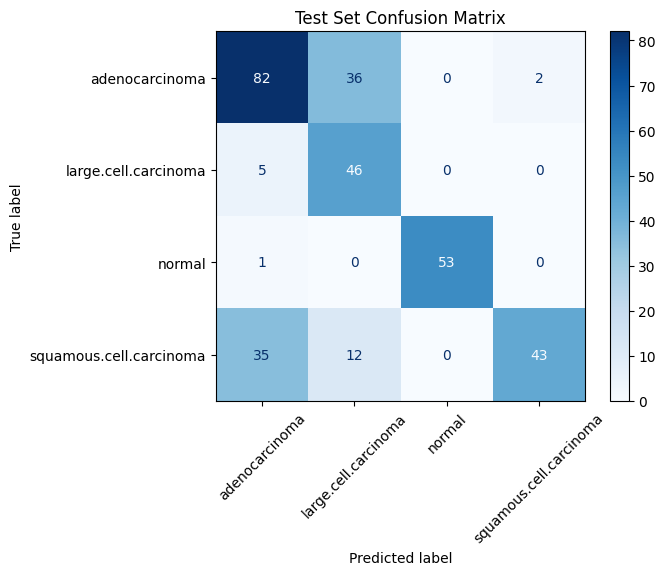

In [12]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.show()


In [13]:
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")



✅ Test Accuracy: 71.11%
